In [224]:
import os
import torch
th = torch
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from random import randint
InteractiveShell.ast_node_interactivity = "all"
torch.set_printoptions(precision=3, sci_mode=False)

# LOAD DATASET

In [693]:
import pickle
dfs = pickle.load(open('scaled_companies_data.pkl', 'rb'))

In [663]:
dfs

{'tesla':                close  close_nasdaq_composite  close_sp_500  close_dow_jones
 Date                                                                       
 2020-01-02  0.011927                0.232898      0.338239         0.484405
 2020-01-03  0.014130                0.225444      0.330615         0.473379
 2020-01-06  0.015604                0.230736      0.334404         0.476608
 2020-01-07  0.018631                0.230434      0.331388         0.470966
 2020-01-08  0.022618                0.236765      0.336648         0.478574
 ...              ...                     ...           ...              ...
 2024-04-08  0.385859                0.980354      0.982777         0.956891
 2024-04-09  0.395966                0.985852      0.985270         0.956461
 2024-04-10  0.382698                0.971629      0.968939         0.936562
 2024-04-11  0.390057                1.000000      0.981674         0.936448
 2024-04-12  0.380858                0.972122      0.956599        

In [694]:
pc_train = 0.2

names = list(dfs.keys())
T = len(dfs[names[0]])
n_train = int(pc_train * T)

dfs_train, dfs_test = {}, {}
for _name, _df in dfs.items():
    dfs_train[_name] = _df.iloc[:len(_df) - n_train]
    dfs_test[_name] = _df.iloc[len(_df) - n_train:]

n_train_per_company = len(dfs_train[_name])
n_test_per_company = len(dfs_test[_name])

print('# of Companies: {} | # of Price Points: {}'.format(len(names), T))
print('Companies: ')
print(names)

# of Companies: 10 | # of Price Points: 1077
Companies: 
['tesla', 'salesforce', 'goldman_sachs', 'microsoft', 'delta_airlines', 'apple', 'visa', 'ford', 'dell', 'alphabet']


In [695]:
dfs[_name].index.strftime('%Y-%m-%d').tolist()

['2020-01-02',
 '2020-01-03',
 '2020-01-06',
 '2020-01-07',
 '2020-01-08',
 '2020-01-09',
 '2020-01-10',
 '2020-01-13',
 '2020-01-14',
 '2020-01-15',
 '2020-01-16',
 '2020-01-17',
 '2020-01-21',
 '2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-27',
 '2020-01-28',
 '2020-01-29',
 '2020-01-30',
 '2020-01-31',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-06',
 '2020-04-

,close,close_nasdaq_composite,close_sp_500,close_dow_jones
Date,,,,
2020-01-02,0.011927,0.232898,0.338239,0.484405
2020-01-03,0.014130,0.225444,0.330615,0.473379
2020-01-06,0.015604,0.230736,0.334404,0.476608
2020-01-07,0.018631,0.230434,0.331388,0.470966
2020-01-08,0.022618,0.236765,0.336648,0.478574
...,...,...,...,...
2020-10-30,0.272787,0.422784,0.342253,0.372826
2020-11-02,0.283558,0.427587,0.355604,0.392786
2020-11-03,0.303763,0.448770,0.375134,0.418945


## Load BERT embedder

In [226]:
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# embedder = BertModel.from_pretrained('bert-base-uncased')

from transformers import LongformerModel, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from
_pretrained("allenai/longformer-base-4096")
embedder = LongformerModel.from_pretrained("allenai/longformer-base-4096")
max_token_n = 4096

# test model
text = 'TWEETS' * 1000
encoded_input = tokenizer(text, return_tensors='pt')
print(encoded_input.input_ids.shape)
_  = embedder(**encoded_input)

torch.Size([1, 3002])


## Dataset generation methods

In [671]:
from sklearn.decomposition import PCA

def embed_by_bert(text):
    _tkn = tokenizer(text, return_tensors='pt') 
    if _tkn.input_ids.shape[-1] >= max_token_n:
        _tkn = _tkn[:,:max_token_n]
    _emb = embedder(**_tkn).last_hidden_state[:,0,:].detach().to(th.float32)
    return _emb

def embed_one_by_one(list_list_texts, text_to_emb_dict, embed_func=None):
    embs = []
    for _i, _txts in enumerate(list_list_texts):
        _embs = []
        for _txt in _txts:
            if _txt in text_to_emb_dict: 
                _emb = text_to_emb_dict.get(_txt)
            else:
                _emb = embed_func(_txt)
                text_to_emb_dict[_txt] = _emb
            _embs.append(_emb)
        embs.append(_embs)
    return embs

def embed_text(dataset, list_list_texts, apply_pca=True):
    unique_embs = dict()
    dataset.unique_embs = unique_embs

    list_list_embs_p_step = embed_one_by_one(list_list_texts, unique_embs, embed_by_bert)
    list_embs_p_company = [th.cat(_embs, dim=0) for _embs in list_list_embs_p_step]
    
    #print(unique_embs)
    
    if apply_pca is not None:
        apply_pca = {} if apply_pca is True else apply_pca
        n_components = apply_pca if isinstance(apply_pca, int) else apply_pca.get('n_components', 10)
        
        # create concatenated embedding
        unique_embs_txts, unique_embs_vals = list(zip(*unique_embs.items()))
        unique_embs_cat = th.cat(unique_embs_vals, dim=0)
        
        # apply PCA
        n_components = min(n_components, len(unique_embs_txts))
        pca = PCA(n_components=n_components)
        pca.fit(unique_embs_cat.numpy())
        
        #  transform
        unique_embs_pca_cat = th.tensor(pca.transform(unique_embs_cat))
        unique_embs_pca = dict(zip(unique_embs.keys(), th.split(unique_embs_pca_cat, 1)))
        dataset.unique_embs_pca = unique_embs_pca
        
        #print(unique_embs_pca)
        # recreate datastructure
        list_list_embs_p_step_pca = embed_one_by_one(list_list_texts, unique_embs_pca)
        list_embs_p_company = [th.cat(_embs, dim=0).to(th.float32) for _embs in list_list_embs_p_step_pca]

    return list_embs_p_company

In [700]:

import torch
from torch.utils.data import Dataset, DataLoader
import pickle

class StockDataset(Dataset):
    def __init__(self, data, 
                 input_window=4, output_window=1,
                 use_transformer=False, 
                 input_prices=['Close_x', 'Close_y'], output_prices=['Close_x'], 
                 include_text= False, apply_pca=10, # or False
                ):
        """
        Args:
        data (filepath of saved path)
        data (list of pd.DataFrame): List of dataframes, each containing columns:
                                          'time', 'stock price', 'stock index price', 'text message'
        input_window (int): Number of timesteps in each input sequence.
        output_window (int): Number of timesteps in each target sequence.
        
        """
        
        self.sequences = [] # store chunks (data point)
        self.sequences_raw = []   # store a company's entire time series sequence 
        self.sequences_raw_embs = [] # store a company's entire time series sequence (text embeddings including PCA if applied)
        self.unique_embs = {}
        self.unique_embs_pca = {}
        
        self.names = []
        self.dates = []
        
        self.apply_pca = apply_pca
        
        if use_transformer:
            output_window = 1
        
        if isinstance(data, str) and os.path.exists(data):
            self.sequences, self.sequences_raw, self.sequences_raw_embs, \
            self.unique_embs, self.unique_embs_pca = pickle.load(open(data, 'rb'))
        else:
            self.input_window = input_window
            self.output_window = output_window
        
            if include_text:
                all_texts = [_df[include_text].values.tolist() for _df in data]
                list_embs_p_company = self.embed_text(all_texts)

            for _i_df, (_name, df) in enumerate(data.items()):
                self.names.append(_name)
                if _i_df == 0:
                    self.dates = df.index.strftime('%Y-%m-%d').tolist()
                
                t = df[input_prices].shape[0]
                seq_in = th.tensor(df[input_prices].values).reshape(t,-1).to(th.float32)
                self.sequences_raw.append(seq_in)
                
                seq_tgt = th.tensor(df[output_prices].values).reshape(t,-1).to(th.float32)
                if include_text:
                    embs = list_embs_p_company[_i_df]
                    self.sequences_raw_embs.append(embs)

                num_sequences = t - self.input_window - self.output_window + 1

                for i in range(num_sequences):
                    input_start = i
                    input_end = i + self.input_window
                    
                    target_start = input_start + 1
                    target_end = input_end + 1

                    seq_in_ = [seq_in[input_start:input_end]]
                    if include_text:
                        seq_in_.append(embs[input_start:input_end])

                    seq_in_ = th.cat(seq_in_, dim=1)
                    seq_tgt_ = seq_tgt[target_start:target_end]
                    self.sequences.append((seq_in_, seq_tgt_, th.tensor([[_i_df, input_start, target_end]])))

    def embed_text(self, list_list_texts):
        return embed_text(self, list_list_texts, apply_pca=self.apply_pca)
    
    def save_dataset(self, filepath):
        pickle.dump([self.sequences, self.sequences_raw, self.sequences_raw_embs, 
                     self.unique_embs, self.unique_embs_pca], open(filepath, 'wb'))
        
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        input_sequence, target_sequence, idx, = self.sequences[idx]
        return input_sequence, target_sequence, idx

    def get_sequence_from_index(self, index, embed_with_empty=False):
        i_company, i_start, _ = index.squeeze().tolist()
        seq = seq_vals = self.sequences_raw[i_company][i_start:].unsqueeze(0)
        len_seq = seq.shape[1]
        
        if self.unique_embs:
            if embed_with_empty:
                unique_embs = self.unique_embs_pca if self.apply_pca else self.unique_embs
                seq_emb = unique_embs[''].to(th.float32).unsqueeze(0).repeat(1, len_seq, 1)
            else:
                seq_emb = self.sequences_raw_embs[i_company][i_start:].unsqueeze(0)
            seq = th.cat((seq_vals, seq_emb), dim=2)
        return seq

    def get_sequence_by_name_date(self, name, date=None, embed_with_empty=False):
        i_company = self.names.index(name)
        i_start = self.dates.index(date) if date else 0
        
        seq = seq_vals = self.sequences_raw[i_company][i_start:].unsqueeze(0)
        len_seq = seq.shape[1]
        
        if self.unique_embs:
            if embed_with_empty:
                unique_embs = self.unique_embs_pca if self.apply_pca else self.unique_embs
                seq_emb = unique_embs[''].to(th.float32).unsqueeze(0).repeat(1, len_seq, 1)
            else:
                seq_emb = self.sequences_raw_embs[i_company][i_start:].unsqueeze(0)
            seq = th.cat((seq_vals, seq_emb), dim=2)
        return seq
        
    @property
    def input_dim(self):
        return self.sequences[0][0].shape[-1]
    @property
    def output_dim(self):
        return self.sequences[0][1].shape[-1]



tensor([[[0.012, 0.233, 0.338, 0.484],
         [0.014, 0.225, 0.331, 0.473],
         [0.016, 0.231, 0.334, 0.477],
         ...,
         [0.475, 0.651, 0.657, 0.682],
         [0.492, 0.666, 0.678, 0.715],
         [0.502, 0.665, 0.675, 0.706]]])

In [687]:
# debugging tool: ignore

def reduce(x, apply=False):
    if apply:
        return th.linalg.norm(x) 
    return x
    
def inspect_model(model, save_data=False, apply_reduce=False, show_grad=True):
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"Layer: {name}")
            print("Weights:",reduce(param.data, apply_reduce))
            if isinstance(save_data, dict):
                save_data.setdefault('w', {})[name] = param.data
                save_data.setdefault('g', {})[name] = param.grad
            if show_grad:
                if param.grad is not None:
                    print("Gradients:", reduce(param.grad, apply_reduce))
                else:
                    print("Gradients: None (check if backward has been called and if the parameter requires gradients)")
            #break
            print('-'*80)


# DATASET

In [303]:
# pickle.dump(DATA, open(FILEPATH, 'wb'))

In [304]:
# DATA = pickle.load(open(FILEPATH, 'rb'))

## Important parameters

In [305]:
input_window = seq_length = 30  # e.g., 5 days input
output_window = 1  # e.g., 2 days to predict

## Fake Data

In [306]:
# # Example fake data generation

# np.random.seed(42)
# data_length = 10
# df1 = pd.DataFrame({
#     'time': pd.date_range(start='1/1/2020', periods=data_length, freq='D'),
#     'price_main': np.random.rand(data_length) * 100,
#     'price_sec': np.random.rand(data_length) * 1000,
#     'text': np.random.choice(['news', '', 'alert', 'none'], data_length)
# })

# df2 = pd.DataFrame({
#     'time': pd.date_range(start='1/1/2020', periods=data_length, freq='D'),
#     'price_main': np.random.rand(data_length) * 100,
#     'price_sec': np.random.rand(data_length) * 1000,
#     'text': np.random.choice(['announcement', 'report', 'alert', 'none'], data_length)
# })

# dataframes = [df1, df2]

* you will need to replace this with your own data
* each df relates to a company
* additionally, normalise your company's price data from 0 to 1
* the stock prices should be normalised the same way across all companies
* here 'price_main' and 'price_sec' represents 'stock' and 'stock index'


## Make dataset

* the dataset generator can be used to make data for different model architecture...
* you can have it predict from stock and index price, and output in stock price... you can also include index price in the output... adjust the output_prices accordingly

In [698]:
name_stock_indices = ['close_nasdaq_composite', 'close_sp_500', 'close_dow_jones']

input_prices = ['close'] + name_stock_indices
output_prices = ['close'] + name_stock_indices
text_column = None  #'Text'

apply_pca = 10  # only relevant when there are text embeddings

In [699]:
dataset_train = StockDataset(dfs_train, 
                             input_window, output_window, 
                             input_prices=input_prices, output_prices=output_prices, include_text=text_column,
                             apply_pca=apply_pca)
dataset_test = StockDataset(dfs_test, 
                            input_window, output_window, 
                            input_prices=input_prices, output_prices=output_prices, include_text=text_column,
                            apply_pca=apply_pca)

n_train = len(dataset_train)
n_test = len(dataset_test)
print("Dataset size (total): Train: {} & Test: {}".format(n_train, n_test))
print("Dataset size (per company): Train: {} & Test: {}".format(n_train_per_company, n_test_per_company))



Dataset size (total): Train: 8320 & Test: 1850
Dataset size (per company): Train: 862 & Test: 215


In [701]:
# example on how to get particular subsequence for date and company:
dataset_train.get_sequence_by_name_date('tesla', '2020-01-02')

tensor([[[0.012, 0.233, 0.338, 0.484],
         [0.014, 0.225, 0.331, 0.473],
         [0.016, 0.231, 0.334, 0.477],
         ...,
         [0.475, 0.651, 0.657, 0.682],
         [0.492, 0.666, 0.678, 0.715],
         [0.502, 0.665, 0.675, 0.706]]])

In [697]:
# # old data ; here for testing purpose

# input_prices = ['Close_x']
# output_prices = ['Close_x']
# text_column = 'Text'
# # dfs['Close_x'] = dfs['Close_x']/400.
# # dfs['Close_x'] /= 100.
# dataset_train = StockDataset([dfs], 
#                              input_window, output_window, 
#                              input_prices=input_prices, output_prices=output_prices, include_text=text_column,
#                              apply_pca=apply_pca)
# dataset_test = dataset_train

In [585]:
dataset_train.get_sequence_from_index(th.tensor([0, 5, 0])).shape

torch.Size([1, 857, 4])

In [ ]:
# if there is text... there will be an embedding corresponding to empty/no text:
dataset.unique_embs_pca[''].numel()

In [653]:
dfs[0].index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04',
               '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10',
               '2024-04-11', '2024-04-12'],
              dtype='datetime64[ns]', name='Date', length=1077, freq=None)

In [14]:
# to save
# dataset_train.save_dataset('file_name.p')

In [722]:
# dataset_train = StockDataset('file_name.p')

# MODELLING

In [606]:

def autoregressive_predict(model, initial_sequence, 
                           n_future_steps, truth=None):
                           #with_text_embed=None):
    """
    Predict 'future_steps' into the future based on the 'initial_sequence' using the provided model.
    
    Args:
        model (nn.Module): The trained time series forecasting model.
        initial_sequence (torch.Tensor): The initial data sequence used for the first prediction, shape [1, seq_length, 1].
        future_steps (int): Number of future steps to predict.

        with_test_embed: text embedding: 2 options
          'empty': always feed in 'empty' for future
          'truth': feed in entire sequence of embedding beginning with first time step of input token

    Returns:
        torch.Tensor: Predicted values for 'future_steps', shape [1, future_steps, 1].
    """
    _ = model.eval()

    if initial_sequence.dim() == 1:
        initial_sequence = initial_sequence.unsqueeze(0).unsqueeze(2)
    elif initial_sequence.dim() == 2:
        initial_sequence = initial_sequence.unsqueeze(0)
    current_sequence = initial_sequence.clone().detach()
        
    dim_truth = 0
    dim_in = initial_sequence.shape[-1]
    if truth is not None:
        dim_truth = truth.shape[-1]
        
    len_inp = initial_sequence.shape[1]
    t = th.arange(len_inp).reshape(len_inp)
    #print('seq len: {} // dim in: {}'.format(len_inp, dim_in))
    
    all_sequences = []
    predictions = []
    
    for step in range(n_future_steps):
        # Predict the next step
        with torch.no_grad():
            next_value = model(current_sequence)
        dim_out = next_value.shape[-1]
        
        # Append the prediction
        predictions.append(next_value[:, -1, :].unsqueeze(1))
    
        # Update the current sequence for the next prediction
        if dim_out < dim_in:
            assert truth is not None # make sure truth is provided when output dim is different than input dim
            _next_value = next_value[:,-1,:].unsqueeze(1)
            _next_value_truth = truth[:, len_inp + step: len_inp + step + 1, dim_out:]
            #print(_next_value.shape, _next_value_truth.shape)
            next_value = th.cat((_next_value, _next_value_truth), dim=2)
            current_sequence = torch.cat((current_sequence[:,1:,:], next_value), dim=1)
        else:
            a, b = (current_sequence[:, 1:, :], next_value[:, -1, :input_dim].unsqueeze(1))
            current_sequence = torch.cat((a, b), dim=1)

        all_sequences.append((t + step + 1, current_sequence))
    
    return torch.cat(predictions, dim=1), all_sequences


In [607]:
import torch
import torch.nn as nn
import numpy as np

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, num_layers, dropout=0.1, apply_input_mask=None):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model

        # Separate embeddings for input and output dimensions
        self.input_linear = nn.Linear(input_dim, d_model)
        self.output_linear = nn.Linear(d_model, output_dim)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.apply_input_mask = apply_input_mask

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=4,  # Adjust number of heads as needed
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, src, src_mask=None):
        if model.training and self.apply_input_mask is not None:  # look ahead mask; for transformer
            input_window = src.shape[1]
            n_tks_to_mask = randint(*self.apply_input_mask)
            mask = torch.ones(input_window, input_window).triu(diagonal=n_tks_to_mask)
 
        # src shape expected: [batch_size, seq_length, input_dim]
        src = self.input_linear(src)  # Transform input to feature space
        src *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))  # Scale input
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)  # Pass through transformer
        output = self.output_linear(output)  # Map output to the target dimension
        return output

    autoregress = autoregressive_predict

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=True):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        self.batch_first = batch_first
        if batch_first:
            pe = torch.zeros(1, max_len, d_model) # batch_first
            pe[0, :, 0::2] = torch.sin(position * div_term)
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_len, 1, d_model) # batch_first
            pe[:, 0, 0::2] = torch.sin(position * div_term)
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(x.shape)
        if self.batch_first:
            x = x + self.pe[:,:x.size(1),:]
        else:
            x = x + self.pe[x.size(0),:,:]
        return x

In [608]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=50, num_layers=2):
        super(TimeSeriesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, d_model, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(d_model, output_dim)
    def forward(self, x, **kwargs):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out)
        return output
    autoregress = autoregressive_predict

In [590]:
# OLD
# class TimeSeriesTransformer(nn.Module):
#     def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
#         super(TimeSeriesTransformer, self).__init__()
#         self.input_linear = nn.Linear(input_dim, d_model)
#         self.pos_encoder = PositionalEncoding(d_model, dropout)
#         encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
#         self.output_linear = nn.Linear(d_model, output_dim)

#     def forward(self, src):
#         #print(src.dtype)
#         src = self.input_linear(src)  # [batch_size, seq_len, d_model]
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src)
#         output = self.output_linear(output)
#         return output

#     def init_weights(self):
#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 if param.dim() > 1:
#                     nn.init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
#                 elif 'norm' in name:
#                     nn.init.constant_(param, 1)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0)

#         # Optionally set a different initialization for embeddings if needed


## Key Model Parameters

In [591]:
# Parameters
input_dim = dataset_train.input_dim # dim_1
output_dim = dataset_train.output_dim   # dim_2
d_model = 32  # Size of the embedding

model_type = 'lstm' # or 'lstm'

# for both models
num_layers = 3

# only for transformers
apply_input_mask = (2, 5) # make sure upper limit is lower than input_window
dim_feedforward = 256
nhead = 4

if model_type == 'lstm':
    learning_rate = 0.01
elif model_type == 'transformer':
    learning_rate = 0.0001

In [592]:
print('Current dim: input {} output {}'.format(input_dim, output_dim))

Current dim: input 4 output 4



### Create fake model & data to test

In [593]:
# Model Test
if model_type == 'transformer':
    model = TimeSeriesTransformer(input_dim, output_dim, d_model, num_layers, apply_input_mask = apply_input_mask)
elif model_type == 'lstm':
    model  = TimeSeriesLSTM(input_dim, output_dim, d_model, num_layers)

# Forward pass with dummy data
# input_data = torch.randn(8, seq_length, input_dim)  
# target_data = torch.randn(8, seq_length, input_dim)  
# Forward pass with real data
input_data = dataset[0][0].unsqueeze(0)

model.eval()
print ('testing ')
output = model(input_data)
print ('testing autoregress...')
model.autoregress(output, 7)[0]
print(input_data.shape, output.shape)  # Should be torch.Size([batch_size, seq_len, output_dim])

# model.init_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

TimeSeriesLSTM(
  (lstm): LSTM(4, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

testing 
testing autoregress...


tensor([[[ 0.167, -0.228, -0.003, -0.177],
         [ 0.167, -0.228, -0.003, -0.177],
         [ 0.167, -0.228, -0.003, -0.177],
         [ 0.167, -0.228, -0.003, -0.177],
         [ 0.167, -0.228, -0.003, -0.177],
         [ 0.167, -0.228, -0.003, -0.177],
         [ 0.167, -0.228, -0.003, -0.177]]])

torch.Size([1, 30, 4]) torch.Size([1, 30, 4])


# Training Prep

In [610]:
# Model loss

def SMAPELoss(output, target,tol=1e-4):
    denominator = (torch.abs(target) + torch.abs(output) + tol) / 2
    diff = torch.abs(output - target) / denominator
    diff[denominator == 0] = 0.0  # Handle the case to avoid division by zero
    smape = torch.mean(diff)
    return smape


In [497]:
batch_size = 24   # make bigger
epochs = 100

In [618]:
# Create data loader

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [435]:
criterion = SMAPELoss
# criterion = nn.MSELoss()

In [599]:
from torch.nn.utils import clip_grad_norm_

# Training and Testing Loop
losses = {}

debug_data_save = False
data = []
data_test = []

for epoch in range(epochs):

    loss_e_train = 0.
    _data = [] 
    _ = model.train()
    for batch, (src, tgt, idx) in enumerate(dataloader_train):
        
        optimizer.zero_grad()
        output = model(src)

        loss = criterion(output, tgt)
        if debug_data_save:
            _data.append((src, output.detach(), tgt))
        
        loss.backward()
        _ = clip_grad_norm_(model.parameters(), max_norm=1.) 
        optimizer.step()
        loss_e_train += loss.detach().item()

    data.append(_data)
    loss_e_train /= batch
    losses.setdefault('train', {})[epoch]=loss_e_train
    
    loss_e_test = 0
    _ = model.eval()
    with torch.no_grad():
        for batch, (src, tgt, idx) in enumerate(dataloader_test):
            _data = []
            output = model(src)
            loss = criterion(output, tgt)
            loss_e_test += loss.item()
            if debug_data_save:
                _data.append((src, output.detach(), tgt))
        data_test.append(_data)
    loss_e_test /= batch
    losses.setdefault('test', {})[epoch]=loss_e_test
    
    print(f"Epoch {epoch+1}, Training Loss: {loss_e_train}, Testing Loss: {loss_e_test}")
    #break

Epoch 1, Training Loss: 0.16478215893353684, Testing Loss: 0.04805322257535798
Epoch 2, Training Loss: 0.059862137815209826, Testing Loss: 0.04267607104371895
Epoch 3, Training Loss: 0.048740013437937796, Testing Loss: 0.03301194119085739
Epoch 4, Training Loss: 0.04724190615096016, Testing Loss: 0.027095852613255575
Epoch 5, Training Loss: 0.04557990064209252, Testing Loss: 0.02644668265499852
Epoch 6, Training Loss: 0.04478616986122262, Testing Loss: 0.041216261878416136
Epoch 7, Training Loss: 0.043319640218177975, Testing Loss: 0.02837258391082287
Epoch 8, Training Loss: 0.0408449756530668, Testing Loss: 0.026267344736820693
Epoch 9, Training Loss: 0.04025185912998253, Testing Loss: 0.04169589445575491
Epoch 10, Training Loss: 0.0396651451265967, Testing Loss: 0.029039114302435477
Epoch 11, Training Loss: 0.03832762782607292, Testing Loss: 0.032569811546376774
Epoch 12, Training Loss: 0.03871918763060962, Testing Loss: 0.02946248756987708
Epoch 13, Training Loss: 0.0384879413496896

KeyboardInterrupt: 

KeyError: ''

# VISUALISATION

In [648]:
import matplotlib.pyplot as plt
from math import pow

def visualize_forecast(seq_to_test_pred_per_step, seq_to_test_truth):
    seq_to_test_truth = seq_to_test_truth[0,:,0]
    
    seq_len_pred = len(seq_to_test_pred_per_step)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(th.arange(input_window).tolist(), seq_to_test_truth[:input_window], c='black')
    ax.plot(th.arange(input_window-1, input_window+seq_len_pred), seq_to_test_truth[input_window-1:input_window+seq_len_pred], c='red')
    
    for _step, (_t, _seq) in enumerate(seq_to_test_pred_per_step):
        _seq = _seq[0,:,:1]  # only show stock price (first dimension of output)
        _is_future = _t >= (input_window - 1)
        _ = ax.plot(_t[_is_future], _seq[_is_future], c='magenta', alpha=pow(0.8, _step))

    plt.show()


# INSPECTION

## Using the model

In [649]:
dataloader_test_shuffled = DataLoader(dataset_test, batch_size=1, shuffle=True)
seq_to_test = next(iter(dataloader_test_shuffled))
#seq_to_test = dataset_test[0] # a random test dataset point

n_future_steps = 7 # how many steps to forecast into the future
use_empty_text = True  # future text is assumed to be empty if True; otherwise, use true text from future

seq_to_test_idx = seq_to_test[2].squeeze() # get the index
print("Test data point information: company: {} & time: {}".format(seq_to_test_idx[0].item(), seq_to_test_idx[0].item()))

# get the corresponding raw data sequence from the dataset beginning from the start of this subsequence
seq_to_test_truth = dataset_test.get_sequence_from_index(seq_to_test_idx, use_empty_text) 
seq_to_test_input = seq_to_test[0]

#run model autoregressively
seq_to_test_pred, seq_to_test_pred_per_step =  model.autoregress(seq_to_test_input, n_future_steps, truth=seq_to_test_truth)

Test data point information: company: 0 & time: 0


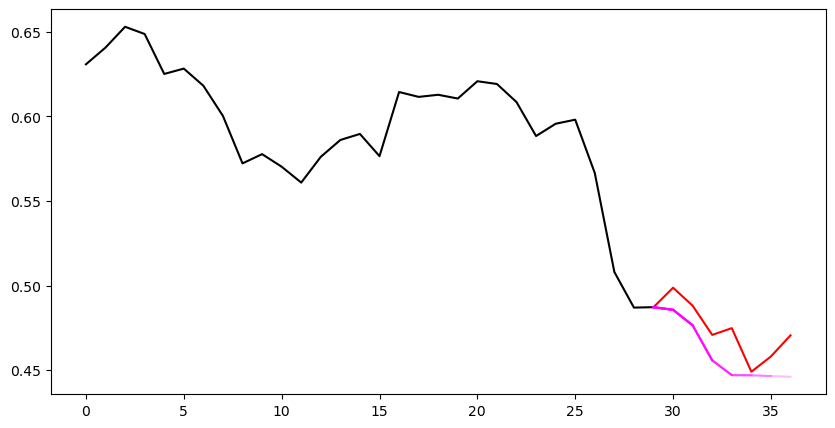

In [650]:
visualize_forecast(seq_to_test_pred_per_step, seq_to_test_truth)